# IFAC 2024 ECG signal features extraction for stress

## Libraries

In [1]:
# General use libraries
import matplotlib.pyplot as plt
import neurokit2 as nk
import pandas as pd
import numpy as np

# Visibility Graph
from ts2vg import NaturalVG
from skimage import transform

# Feature Extraction
import pyfeats
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from lazypredict.Supervised import LazyClassifier


## Functions

In [2]:
def create_VG(sig_dt, w_n, it, limit_p):
    """
    Create a Visibility Graph (VG) from a signal.

    Parameters:
    sig_dt (array-like): The input signal data.
    w_n: weight scheme for the VG.
    it (int): The size to which the adjacency matrix image will be resized.
    limit_p (int): The penetrable limit for the VG.

    Returns:
    np.ndarray: The resized adjacency matrix image.
    """
    sig_n = sig_dt

    # Build the Natural Visibility Graph (VG)
    nvg = NaturalVG(weighted=w_n, penetrable_limit=limit_p).build(sig_n)
    
    # Get the adjacency matrix
    if w_n is None:
        adm = nvg.adjacency_matrix(triangle="both", use_weights=False)
    else:    
        adm = nvg.adjacency_matrix(triangle="both", use_weights=True)
    
    # Replace NaNs with zeros
    adm[np.isnan(adm)] = 0

    # Resize the adjacency matrix image
    images = transform.resize(adm, (it, it), anti_aliasing=True)
   
    return images

def create_windows(signal, window_size, overlap_percentage):
    """
    Split the signal into overlapping windows.

    Parameters:
    signal (array-like): The input signal data.
    window_size (int): The size of each window.
    overlap_percentage (float): The percentage of overlap between consecutive windows.

    Returns:
    tuple: A tuple containing the list of windows and the number of windows.
    """
    overlap_size = int(window_size * overlap_percentage)
    windows = []

    for i in range(0, len(signal) - window_size + 1, window_size - overlap_size):
        window = signal[i:i + window_size]
        if len(window) == window_size:
            windows.append(window)

    return windows, len(windows)

def VG_feat(wind, limit_p, weight, img_size):
    """
    Extract features from a signal window using Visibility Graph (VG) and various image processing techniques.

    Parameters:
    wind (array-like): The input signal window.
    limit_p (int): The penetrable limit for the VG.
    weight: weight scheme for the VG.
    img_size (int): The size to which the adjacency matrix image will be resized.

    Returns:
    tuple: A tuple containing the extracted features and their corresponding labels.
    """
    # Create the Visibility Graph (VG) image
    img = create_VG(wind, w_n=weight, it=img_size, limit_p=limit_p)

    # Create a binary mask from the VG image
    mask = img.copy()
    mask[mask > 0] = 1

    # Extract Zernike moments features
    features_z, labels_z = pyfeats.zernikes_moments(img, radius=9)

    # Extract Hu's moments features
    features_hu, labels_hu = pyfeats.hu_moments(img)

    # Extract Wavelet Packet (WP) features
    features_wp, labels_wp = pyfeats.wp_features(img, mask, maxlevel=3)

    # Combine all features into a single array
    features = np.hstack((features_z, features_hu, features_wp)).reshape(1, -1)

    # Combine all labels into a single list
    labels = np.hstack((labels_z, labels_hu, labels_wp)).reshape(-1,)

    return features, list(labels)

## Load ECG signal data

In [4]:
signal=np.load("Data/ecg_signals.npy",allow_pickle=True).item()

In [5]:
patients=list(signal.keys())
print(patients)

['2107_1', '2126_1', '2123_1', '2124_2', '2113_1', '2122_1', '2110_1', '2121_1', '2104_1', '2114_1', '2131_2', '2120_1', '2112_1', '2115_1', '2117_1', '2119_1', '2130_1', '2131_1', '2109_1', '2129_1', '2116_1', '2134_1', '2133_1', '2105_1', '2111_1', '2108_1', '2132_1', '2127_1', '2106_1', '2124_1', '2125_1', '2136_1']


## Reduce Sample Rate

(201,)


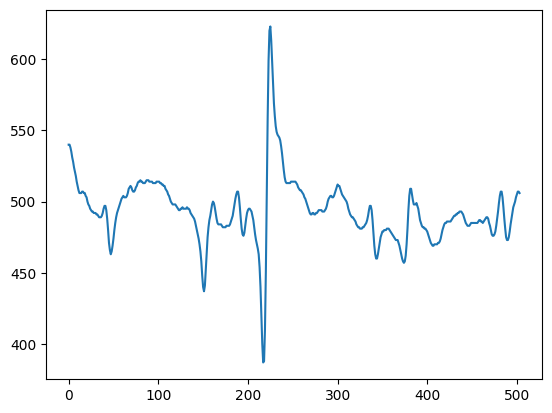

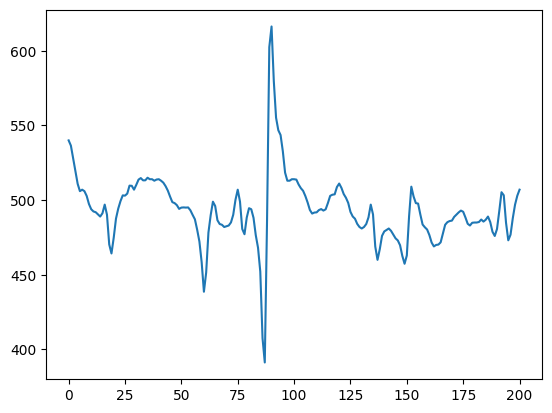

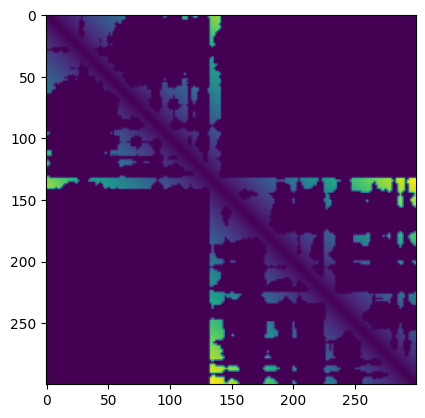

In [6]:
def reduce_sample_rate(signal, original_rate, new_rate):
    
    original_samples = len(signal)
    duration = original_samples / original_rate
    new_samples = int(duration * new_rate)
    reduced_signal = np.interp(
        np.linspace(0, 1, new_samples, endpoint=False),
        np.linspace(0, 1, original_samples, endpoint=False),
        signal
    )
    return reduced_signal
 
si=np.asarray(signal['2105_1'][0]['20_8'][0]).reshape(-1,)
new_rate = 100  # New sample rate (Hz)
original_rate=250
reduced_signal = reduce_sample_rate(si, original_rate, new_rate)

print(reduced_signal.shape)

plt.plot(si[0:1000])
plt.show()

plt.plot(reduced_signal[0:1000])
plt.show()

limit_p=5
weight='abs_h_distance'
img_size=300

img=create_VG(reduced_signal[0:1000],w_n=weight,it=img_size,limit_p=limit_p)

plt.imshow(img)
plt.show()

## Feature extraction

In [9]:
# Windowing parameters
window_size = 100  # Size of each window in samples
overlap_percentage = 0  # Percentage of overlap between consecutive windows

# Visibility graph parameters
limit_p = 0  # Penetrable limit for the visibility graph
new_rate = 10  # Size to which the adjacency matrix should be resized
weight = None  # Weight scheme in the VG. Can be None or "distance"

# Sampling rates
original_rate = 250  # Original sample rate of the EEG signal (Hz)

In [10]:
pac_vt = {}
for pa in patients:
    if not signal[pa][0]:
        print("Pacient " + pa + " is empty.")
    else:
        print("Pacient " + pa + " is correct. Will be added to the database.")
        status = list(signal[pa][0].keys())
        for sta in status:
            sig_pa = np.array(signal[pa][0][sta][0]).reshape(-1,)
            red_sig = reduce_sample_rate(sig_pa, original_rate, new_rate)
            sig_filt = nk.ecg_clean(red_sig, 250, method='vg')
            windows, windo_num = create_windows(sig_filt, window_size, overlap_percentage)
            values_dt = []
            for wind in windows:
                weight = 'abs_h_distance'
                fet3, lab3 = VG_feat(wind, limit_p, None, img_size)
                lab3 = [s + "non" for s in lab3]
                fet = fet3
                lab = lab3
                values_dt.append(fet.copy().reshape(-1,))
            mean_ft = np.mean(np.asarray(values_dt), axis=0)
            dt_mean = np.hstack((mean_ft, sta))
            pac_vt[pa + "_" + sta] = []
            pac_vt[pa + "_" + sta].append(np.asanyarray(dt_mean))

Pacient 2107_1 is correct. Will be added to the database.
Pacient 2126_1 is correct. Will be added to the database.
Pacient 2123_1 is correct. Will be added to the database.
Pacient 2124_2 is correct. Will be added to the database.
Pacient 2113_1 is correct. Will be added to the database.
Pacient 2122_1 is correct. Will be added to the database.
Pacient 2110_1 is correct. Will be added to the database.
Pacient 2121_1 is correct. Will be added to the database.
Pacient 2104_1 is correct. Will be added to the database.
Pacient 2114_1 is correct. Will be added to the database.
Pacient 2131_2 is correct. Will be added to the database.
Pacient 2120_1 is correct. Will be added to the database.
Pacient 2112_1 is correct. Will be added to the database.
Pacient 2115_1 is correct. Will be added to the database.
Pacient 2117_1 is correct. Will be added to the database.
Pacient 2119_1 is correct. Will be added to the database.
Pacient 2130_1 is correct. Will be added to the database.
Pacient 2131_1

In [ ]:
features=pd.DataFrame({key: pd.Series(value[0]) for key, value in pac_vt.items()})
features=features.T
features.columns=np.hstack((lab,"Labels"))
features=features.dropna()

,Zernikes_Moments_radius_9_0non,Zernikes_Moments_radius_9_1non,Zernikes_Moments_radius_9_2non,Zernikes_Moments_radius_9_3non,Zernikes_Moments_radius_9_4non,Zernikes_Moments_radius_9_5non,Zernikes_Moments_radius_9_6non,Zernikes_Moments_radius_9_7non,Zernikes_Moments_radius_9_8non,Zernikes_Moments_radius_9_9non,...,WP_coif1_dvd_stdnon,WP_coif1_dda_meannon,WP_coif1_dda_stdnon,WP_coif1_ddh_meannon,WP_coif1_ddh_stdnon,WP_coif1_ddv_meannon,WP_coif1_ddv_stdnon,WP_coif1_ddd_meannon,WP_coif1_ddd_stdnon,Labels
2107_1_10,0.3183098861837906,0.03957734019964552,0.10281251881775298,0.10467447233749395,0.035190597319938385,0.06675665403582774,0.05099410645533642,0.0479122250268773,0.05765486644410934,0.025088046680546428,...,0.00039482782749003607,0.00035674927653340437,0.0005110205580495574,0.00023869677427765126,0.00029945906385082596,0.00023869677427765126,0.00029945906385082596,0.00037221009810856087,0.0005571599976324024,10
2107_1_20,0.31830988618379064,0.03750372691087802,0.10491398164781855,0.10024429717538476,0.035899566269410356,0.058754760890116546,0.05023541722816434,0.04748413890794383,0.06329009287289984,0.030423059433441778,...,0.0003914755250372883,0.0003497161740829843,0.000491705350830635,0.00024228396710416304,0.0002975375509557032,0.0002422839671041631,0.0002975375509557032,0.0003823662470871359,0.0005564828055948755,20
2107_1_16,0.31830988618378897,0.039498949898899106,0.10473029876521972,0.1068849789660672,0.03215734811072888,0.06446945979056565,0.054188897354163615,0.04499347692844271,0.05850830826888119,0.024189114484186355,...,0.00039225987622403593,0.00036183580541875645,0.0005190852818602064,0.00024191533221707816,0.0003046302816650032,0.00024191533221707816,0.00030463028166500324,0.0003748098602931887,0.0005626114317299367,16
2107_1_26,0.3183098861837921,0.03750737870134388,0.09491801076991667,0.10068101590246284,0.035490869432754604,0.057329144264547056,0.05652081033765537,0.050165911073803915,0.05883003283566618,0.02665140535108086,...,0.000387930082891826,0.00040356606905091896,0.0006247818545386872,0.0002448617039261279,0.00031318397680449707,0.00024486170392612797,0.00031318397680449707,0.00036418733441862796,0.0005442378387240162,26
2107_1_10_1,0.3183098861837906,0.04168167797455141,0.09153025916963667,0.09986340063046627,0.03237238897687155,0.07000801255429842,0.05713109697280972,0.04607750491266075,0.05038103384686772,0.02712164117480691,...,0.0003860163028355022,0.00041427264464403876,0.0006291964664298806,0.0002601011541521118,0.00032824552901584113,0.0002601011541521118,0.0003282455290158412,0.00037760898955875534,0.0005494808438414136,10_1


In [ ]:

features.head()
features.to_csv('ECG_features')

,Zernikes_Moments_radius_9_0non,Zernikes_Moments_radius_9_1non,Zernikes_Moments_radius_9_2non,Zernikes_Moments_radius_9_3non,Zernikes_Moments_radius_9_4non,Zernikes_Moments_radius_9_5non,Zernikes_Moments_radius_9_6non,Zernikes_Moments_radius_9_7non,Zernikes_Moments_radius_9_8non,Zernikes_Moments_radius_9_9non,...,WP_coif1_dvd_stdnon,WP_coif1_dda_meannon,WP_coif1_dda_stdnon,WP_coif1_ddh_meannon,WP_coif1_ddh_stdnon,WP_coif1_ddv_meannon,WP_coif1_ddv_stdnon,WP_coif1_ddd_meannon,WP_coif1_ddd_stdnon,Labels
2107_1_10,0.3183098861837906,0.03957734019964552,0.10281251881775298,0.10467447233749395,0.035190597319938385,0.06675665403582774,0.05099410645533642,0.0479122250268773,0.05765486644410934,0.025088046680546428,...,0.00039482782749003607,0.00035674927653340437,0.0005110205580495574,0.00023869677427765126,0.00029945906385082596,0.00023869677427765126,0.00029945906385082596,0.00037221009810856087,0.0005571599976324024,10
2107_1_20,0.31830988618379064,0.03750372691087802,0.10491398164781855,0.10024429717538476,0.035899566269410356,0.058754760890116546,0.05023541722816434,0.04748413890794383,0.06329009287289984,0.030423059433441778,...,0.0003914755250372883,0.0003497161740829843,0.000491705350830635,0.00024228396710416304,0.0002975375509557032,0.0002422839671041631,0.0002975375509557032,0.0003823662470871359,0.0005564828055948755,20
2107_1_16,0.31830988618378897,0.039498949898899106,0.10473029876521972,0.1068849789660672,0.03215734811072888,0.06446945979056565,0.054188897354163615,0.04499347692844271,0.05850830826888119,0.024189114484186355,...,0.00039225987622403593,0.00036183580541875645,0.0005190852818602064,0.00024191533221707816,0.0003046302816650032,0.00024191533221707816,0.00030463028166500324,0.0003748098602931887,0.0005626114317299367,16
2107_1_26,0.3183098861837921,0.03750737870134388,0.09491801076991667,0.10068101590246284,0.035490869432754604,0.057329144264547056,0.05652081033765537,0.050165911073803915,0.05883003283566618,0.02665140535108086,...,0.000387930082891826,0.00040356606905091896,0.0006247818545386872,0.0002448617039261279,0.00031318397680449707,0.00024486170392612797,0.00031318397680449707,0.00036418733441862796,0.0005442378387240162,26
2107_1_10_1,0.3183098861837906,0.04168167797455141,0.09153025916963667,0.09986340063046627,0.03237238897687155,0.07000801255429842,0.05713109697280972,0.04607750491266075,0.05038103384686772,0.02712164117480691,...,0.0003860163028355022,0.00041427264464403876,0.0006291964664298806,0.0002601011541521118,0.00032824552901584113,0.0002601011541521118,0.0003282455290158412,0.00037760898955875534,0.0005494808438414136,10_1


## Preprocess features

In [ ]:
features_num=features.iloc[:,0:-1]
features_num= features_num.astype(float)

In [ ]:
nan_columns = features_num.columns[features_num.isna().any()].tolist()

print("Columns with NaN values:")
print(nan_columns)

Columns with NaN values:
[]


In [ ]:
nan_rows = features_num[features_num.isna().any(axis=1)]

print("Rows with NaN values:")
print(nan_rows)

Rows with NaN values:
Empty DataFrame
Columns: [Zernikes_Moments_radius_9_0non, Zernikes_Moments_radius_9_1non, Zernikes_Moments_radius_9_2non, Zernikes_Moments_radius_9_3non, Zernikes_Moments_radius_9_4non, Zernikes_Moments_radius_9_5non, Zernikes_Moments_radius_9_6non, Zernikes_Moments_radius_9_7non, Zernikes_Moments_radius_9_8non, Zernikes_Moments_radius_9_9non, Zernikes_Moments_radius_9_10non, Zernikes_Moments_radius_9_11non, Zernikes_Moments_radius_9_12non, Zernikes_Moments_radius_9_13non, Zernikes_Moments_radius_9_14non, Zernikes_Moments_radius_9_15non, Zernikes_Moments_radius_9_16non, Zernikes_Moments_radius_9_17non, Zernikes_Moments_radius_9_18non, Zernikes_Moments_radius_9_19non, Zernikes_Moments_radius_9_20non, Zernikes_Moments_radius_9_21non, Zernikes_Moments_radius_9_22non, Zernikes_Moments_radius_9_23non, Zernikes_Moments_radius_9_24non, Hu_Moment_0non, Hu_Moment_1non, Hu_Moment_2non, Hu_Moment_3non, Hu_Moment_4non, Hu_Moment_5non, Hu_Moment_6non, WP_coif1_aah_meannon, WP_

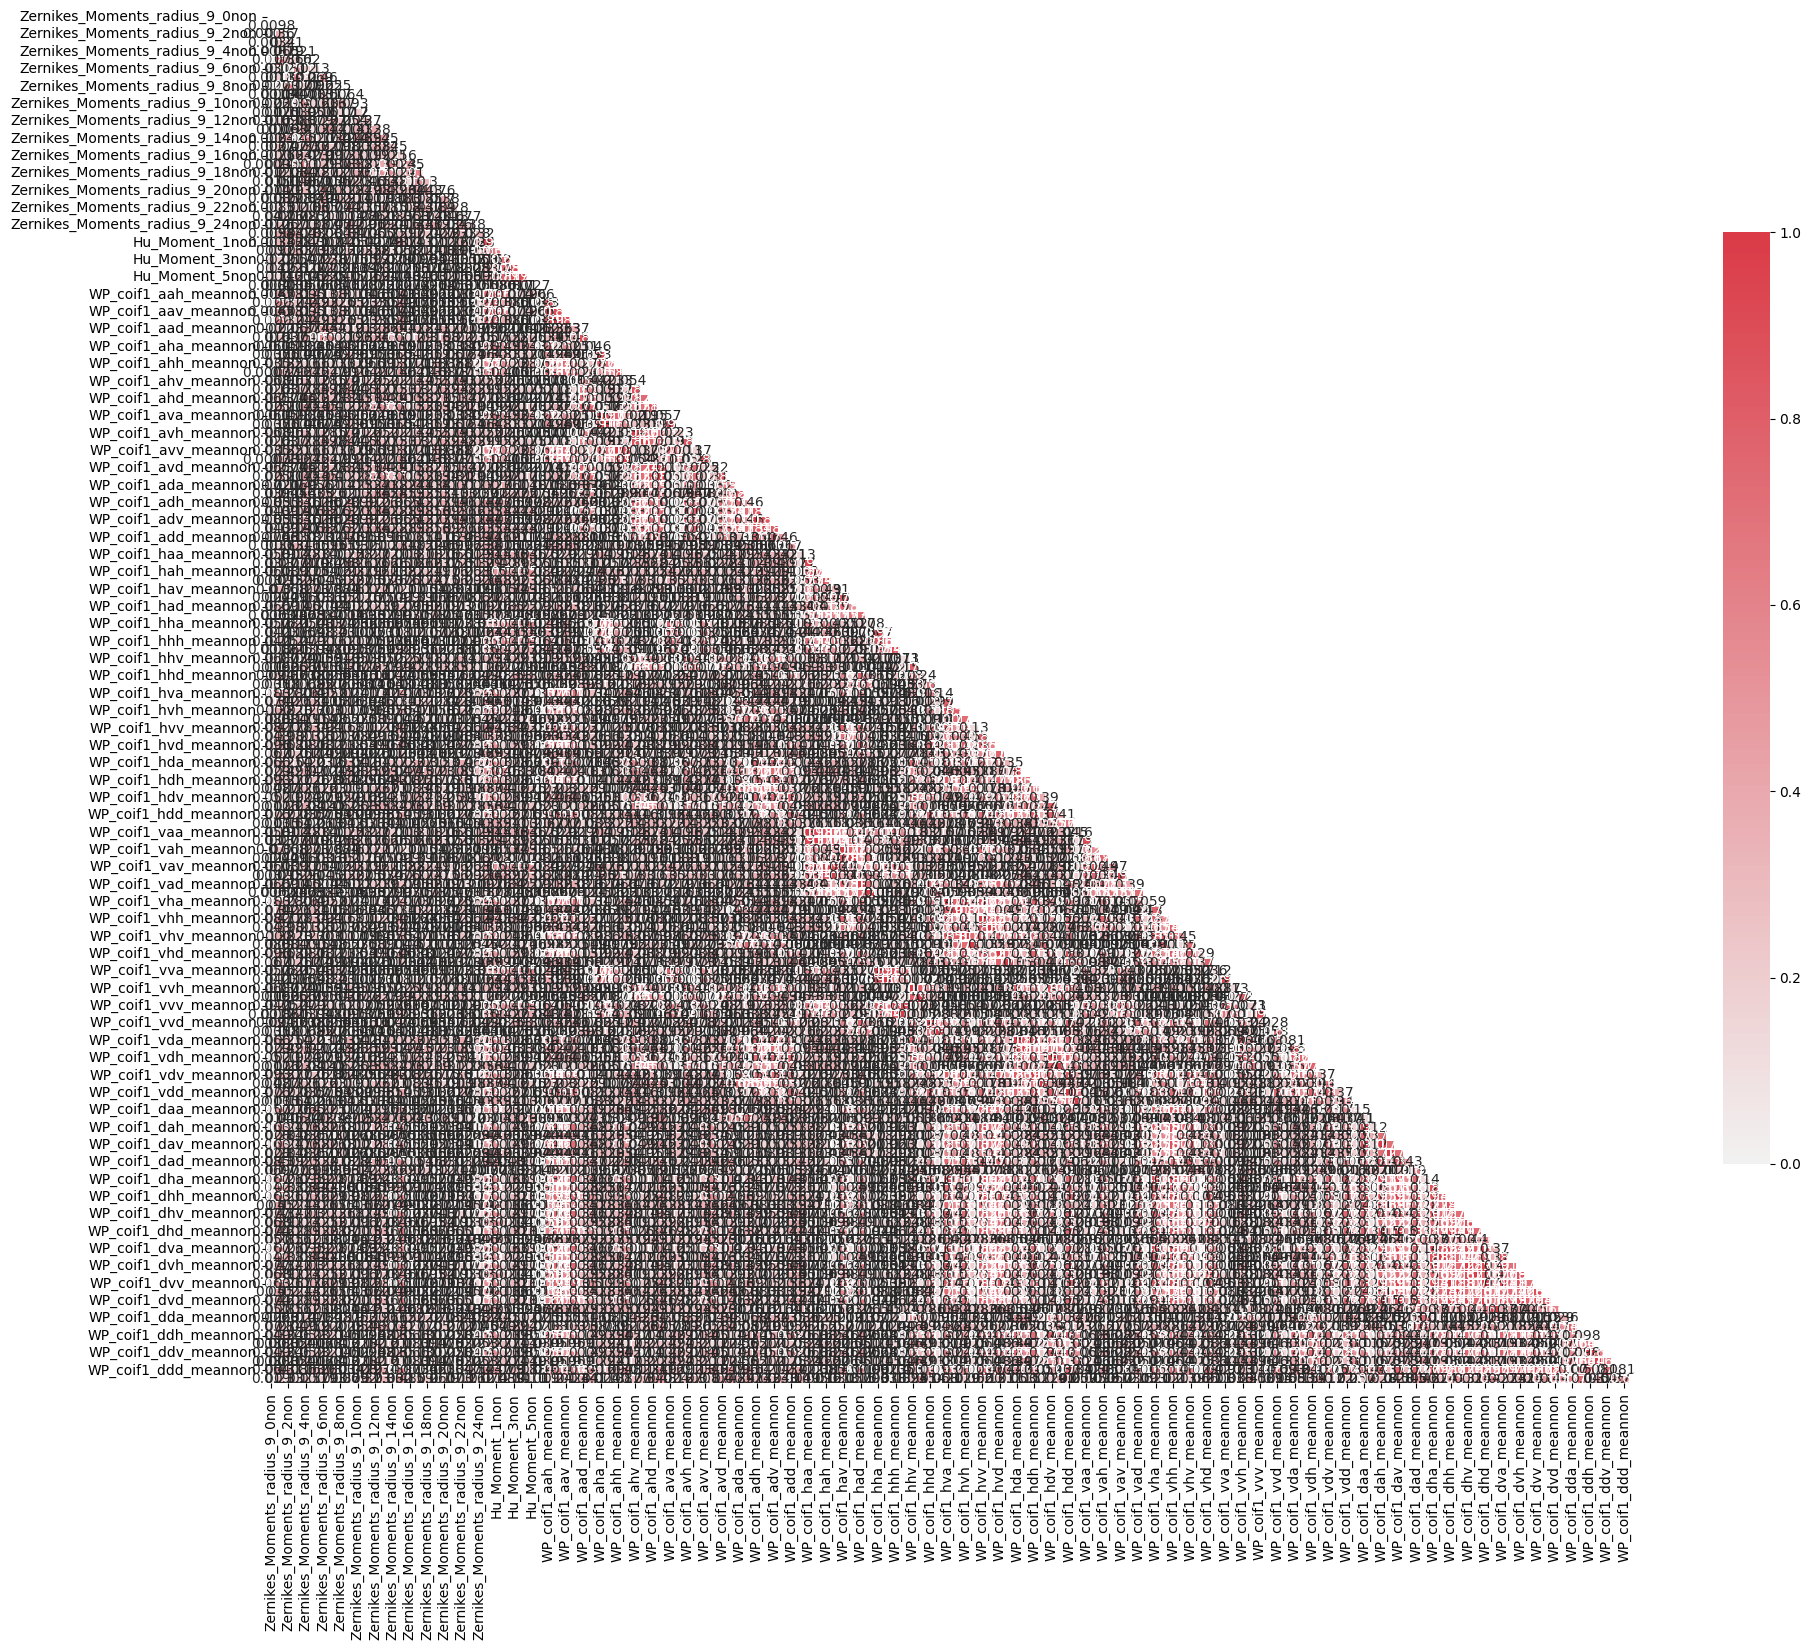

In [ ]:
corr = features_num.corr().abs()

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set figure size
f, ax = plt.subplots(figsize=(20, 20))

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

In [ ]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

In [ ]:
# Compute correlation matrix
df_filtered=remove_collinear_features(features_num,0.5)

Removed Columns {'WP_coif1_vvv_meannon', 'WP_coif1_ada_stdnon', 'WP_coif1_vhv_stdnon', 'WP_coif1_dva_meannon', 'WP_coif1_ahd_stdnon', 'WP_coif1_dad_meannon', 'WP_coif1_vah_meannon', 'WP_coif1_hdv_meannon', 'WP_coif1_vda_meannon', 'WP_coif1_hdd_meannon', 'WP_coif1_aha_stdnon', 'WP_coif1_avh_meannon', 'WP_coif1_vhv_meannon', 'WP_coif1_aav_stdnon', 'WP_coif1_aah_stdnon', 'WP_coif1_had_meannon', 'WP_coif1_avv_stdnon', 'Hu_Moment_3non', 'WP_coif1_avv_meannon', 'WP_coif1_avd_stdnon', 'WP_coif1_adh_meannon', 'WP_coif1_ahv_meannon', 'WP_coif1_daa_meannon', 'Zernikes_Moments_radius_9_18non', 'WP_coif1_dhd_stdnon', 'WP_coif1_dha_meannon', 'WP_coif1_hda_meannon', 'Zernikes_Moments_radius_9_10non', 'WP_coif1_dvv_stdnon', 'WP_coif1_ddv_meannon', 'WP_coif1_hav_meannon', 'WP_coif1_dva_stdnon', 'Zernikes_Moments_radius_9_19non', 'WP_coif1_vda_stdnon', 'WP_coif1_hda_stdnon', 'WP_coif1_adv_stdnon', 'WP_coif1_dav_stdnon', 'WP_coif1_vhh_meannon', 'WP_coif1_vhh_stdnon', 'WP_coif1_vva_meannon', 'WP_coif1_dh

## K-Means Clustering

In [ ]:
data=df_filtered.values
scaler = StandardScaler()
data=scaler.fit_transform(data)

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0)  # Assuming 3 clusters
kmeans.fit(data)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_



## PCA Visualization of Clusters

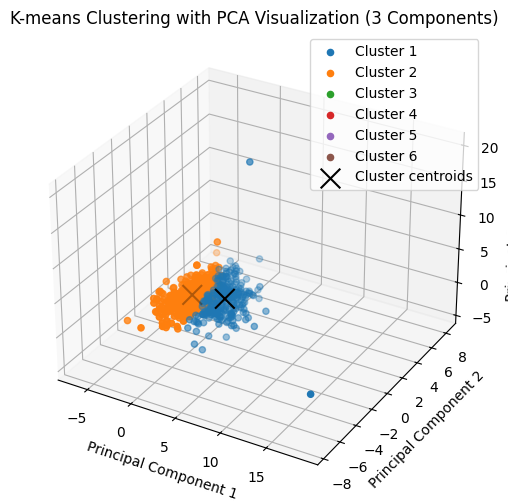

In [ ]:
# Visualize the clustered data using PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(data)


# Plotting the clustered data
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points with different colors for each cluster
for i in range(6):
    ax.scatter(X_pca[kmeans.labels_ == i, 0], X_pca[kmeans.labels_ == i, 1], X_pca[kmeans.labels_ == i, 2], label=f'Cluster {i+1}')

# Plotting the centroids of the clusters
centroids_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2], marker='x', s=200, c='black', label='Cluster centroids')

# Adding labels and title
ax.set_title('K-means Clustering with PCA Visualization (3 Components)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.grid(True)
plt.show()


## Train-Test Split

In [ ]:
df_filtered['target']=features['Labels']

df_filtered= df_filtered[~df_filtered.index.str.contains('20|10')]

unique_patients = df_filtered.index.unique()

train_patients, test_patients = train_test_split(unique_patients, test_size=0.3, random_state=42)

train_data = []
test_data = []

for patient_id in train_patients:
    patient_data = df_filtered.loc[patient_id,:]
    train_data.append(patient_data)

for patient_id in test_patients:
    patient_data = df_filtered.loc[patient_id,:]
    test_data.append(patient_data)

train_data_df=pd.DataFrame(train_data)
test_data_df=pd.DataFrame(test_data)

X_train = train_data_df.drop(columns=['target']) 
y_train = train_data_df['target']

X_test = test_data_df.drop(columns=['target'])
y_test = test_data_df['target']


## Label Transformation

In [ ]:
def change_labels(labels):
    new_labels = []
    for label in labels:
        # Convert the label to an integer for comparison
        label = int(label)
        if label < 14:
            new_labels.append(0)
        else:
            new_labels.append(1)
    return new_labels

# Change labels for Y_train
y_train = change_labels(y_train)

# Change labels for Y_test
y_test = change_labels(y_test)

## Feature Selection

In [ ]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

selec=SelectKBest(f_classif, k=10)

X_train_sel= selec.fit_transform(X_train, y_train)
X_test_sel= selec.transform(X_test)

In [ ]:
selected_feature_indices = selec.get_support(indices=True)
selected_feature_names = df_filtered.columns[selected_feature_indices].tolist()

# Create a bar plot of the selected features
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_feature_names)), selec.scores_[selected_feature_indices])
plt.xticks(range(len(selected_feature_names)), selected_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('ANOVA F-value')
plt.title('Best Selected Features based on ANOVA F-value')
plt.tight_layout()
plt.show()

In [ ]:
print("Sample of selected features:")
selected_features_df = pd.DataFrame(X_train_sel[:5, :], columns=selected_feature_names)
selected_features_df

## Model Training and Evaluation

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_sel, X_test_sel, y_train, y_test)
models

100%|██████████| 31/31 [00:00<00:00, 51.97it/s]

[LightGBM] [Info] Number of positive: 125, number of negative: 43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 168, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.744048 -> initscore=1.067114
[LightGBM] [Info] Start training from score 1.067114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.90,0.88,0.88,0.90,0.07
BaggingClassifier,0.89,0.87,0.87,0.89,0.02
LGBMClassifier,0.88,0.82,0.82,0.87,0.09
RandomForestClassifier,0.88,0.81,0.81,0.87,0.08
DecisionTreeClassifier,0.82,0.80,0.80,0.82,0.01
QuadraticDiscriminantAnalysis,0.82,0.76,0.76,0.81,0.01
GaussianNB,0.78,0.75,0.75,0.78,0.01
XGBClassifier,0.82,0.73,0.73,0.81,0.14
ExtraTreesClassifier,0.74,0.62,0.62,0.71,0.05
